# Prediction with NN
> 2018-11-15 13:11:49  
>
> reference :  https://www.kaggle.com/jamesleslie/titanic-neural-network-for-beginners
## About the missing values?
* train's shape is (891, 12), 'Age' has 714 values, 'Cabin' has 204 values, 'Embarked' has 889 values.
* final_test's shape is (418, 11), "Age" has 332 values, 'Fare' has 417 values, 'Cabin' has 91 values.

Filling the missing age using average Title's age. Filling the missing Fare values using average Pclass's fare; Filling the missing embarked value as S.

Havn't filled the missing Embarked. 

## Which factors can be used as input?
Currently, I used the 'Age','Fare','Parch','SibSp','Pclass','Sex_female','Sex_male',
                    'Embarked_C','Embarked_Q','Embarked_S'

## Tips

 What really helps in this is creating a good cross validation framework so you can get a reliable error estimate
 
 ## Value type
* Numerical Features: Age, Fare, SibSp and Parch
* Categorical Features: Sex, Embarked, Survived and Pclass
* Alphanumeric Features: Ticket and Cabin(Contains both alphabets and the numeric value)
* Text Features: Name

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf # NN
import matplotlib.pyplot as plt
import seaborn as sns

#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split # split train and test set

from time import time
import os
print(os.listdir("../input"))

# read files
path = '../input'
final_test = pd.read_csv(path + '/test.csv') 
train = pd.read_csv(path + '/train.csv')
del path

passengerId = final_test['PassengerId']  # hold it for the submission file

# inspect data
print('train.shape',train.shape,
      '\nfinal_test.shape',final_test.shape)

print('====train info====')
print(train.info())
print('====final test info====')
print(final_test.info())
#train.head(20)
#final_test.head(20)

['gender_submission.csv', 'test.csv', 'train.csv']
train.shape (891, 12) 
final_test.shape (418, 11)
====train info====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
====final test info====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-

In [2]:
# data pre-processing. Since the limited info of cabin, I abandon this column.
# missing age: use the average age of passenger's Title
    
# replace rare titles with more common ones
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr',
           'Don': 'Mr', 'Mme': 'Miss', 'Jonkheer': 'Mr', 'Lady': 'Mrs',
           'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']
# function, extract title and creat new column for it, then filling missing age with average
def fill_missing_age(data):
    #extract title, replace rare ones.
    data["Title"] = data["Name"] # add a new column
    for name in data["Title"]:
        data["Title"] = data["Name"].str.extract('([A-Za-z]+)\.', expand=True)
    data.replace({'Title': mapping}, inplace=True)
    # present missing age with median of Title column
    for title in titles:
        median = data.groupby('Title')["Age"].median()[titles.index(title)]
        data.loc[(data['Age'].isnull()) & (data["Title"] == title), 'Age'] = median
    return data

train = fill_missing_age(train)
final_test = fill_missing_age(final_test)

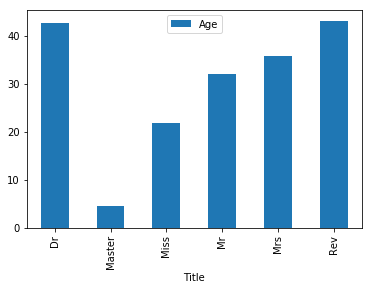

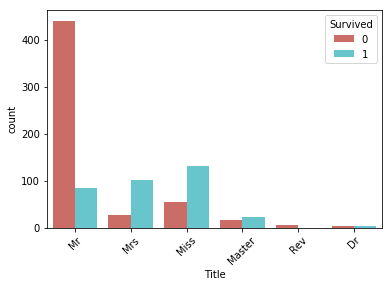

In [3]:
# inspect the average age with Title
train.pivot_table(index='Title',values = 'Age').plot.bar()
plt.show()
# the portion of survival with respect to Title
survived = train[train['Survived'] == 1]
died = train[train['Survived'] == 0]
sns.countplot(x='Title',data=train, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

In [4]:
# For the missing Fare values, using the median fare value of class.
p_classes=[1,2,3]
def fill_missing_fare(data):
    for p_class in p_classes:
        median_fare = data.groupby('Pclass')['Fare'].median()[p_class]
        data.loc[(data['Fare'].isnull()) & (data['Pclass'] == p_class),'Fare' ] = median_fare 
    return data

train = fill_missing_fare(train)
final_test = fill_missing_fare(final_test)

In [5]:
# filling missing embarked value with S
train = train.fillna({"Embarked": "S"})

In [6]:
# Using one hot encoder to perform binarization of the category and include it as a feature
# convert categorical variables into numeric format
#categorical = data[['Pclass', 'Sex']].values
#encoded_vars_temp = []

def create_dummies(data_df,column_name):
    for name in column_name:        
        dummies = pd.get_dummies(data_df[name], prefix=name)
        data_df = pd.concat([data_df, dummies], axis=1)
    return data_df

train = create_dummies(train,['Pclass','Sex','Embarked'])
final_test = create_dummies(final_test,['Pclass','Sex','Embarked']) 
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,0,0,1,0,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1,0,0,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0,0,1,1,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,1,0,0,1,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,0,0,1,0,1,0,0,1


In [7]:
# Scale continuous variables to values between -1 and 1.
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

all_data = train.append(final_test, ignore_index=True)

def scale_var(df,column_names):
    scaler = MinMaxScaler(feature_range=(-1.,1.))
    for name in column_names:
        var_scaled = scaler.fit_transform(df[[name]])
        df[name] = var_scaled  
    return df
all_data = scale_var(all_data,['Age','Fare','SibSp','Parch'])
# bring back to two datasets
#all_data.loc[890:899]
# refine data. reserve values for inputs and outputs.
all_data = all_data [['Survived','Age','Fare','Parch','SibSp','Pclass_1','Pclass_2','Pclass_3','Sex_female','Sex_male',
                    'Embarked_C','Embarked_Q','Embarked_S']]

train = all_data[:890]
final_test = all_data[891:]
all_data

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Survived,Age,Fare,Parch,SibSp,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.0,-0.453088,-0.971698,-1.000000,-0.75,0,0,1,0,1,0,0,1
1,1.0,-0.052236,-0.721729,-1.000000,-0.75,1,0,0,1,0,1,0,0
2,1.0,-0.352875,-0.969063,-1.000000,-1.00,0,0,1,1,0,0,0,1
3,1.0,-0.127396,-0.792711,-1.000000,-0.75,1,0,0,1,0,0,0,1
4,0.0,-0.127396,-0.968575,-1.000000,-1.00,0,0,1,0,1,0,0,1
5,0.0,-0.252662,-0.966981,-1.000000,-1.00,0,0,1,0,1,0,1,0
6,0.0,0.348616,-0.797542,-1.000000,-1.00,1,0,0,0,1,0,0,1
7,0.0,-0.954153,-0.917729,-0.777778,-0.25,0,0,1,0,1,0,0,1
8,1.0,-0.327822,-0.956538,-0.555556,-1.00,0,0,1,1,0,0,0,1
9,1.0,-0.653514,-0.882611,-1.000000,-0.75,0,1,0,1,0,1,0,0


In [8]:
# split the train to train and test, for cross validation
from sklearn.model_selection import train_test_split

# using train dataset for train and test the performance
train_all_y = train[['Survived']]
train_all_x = train[['Age','Fare','Parch','SibSp','Pclass_1','Pclass_2','Pclass_3','Sex_female','Sex_male',
                    'Embarked_C','Embarked_Q','Embarked_S']]


In [ ]:
# test_size control the proportions of data are split into. Randomly split
tr_train_X, tr_test_X, tr_train_y, tr_test_y = train_test_split(train_all_x, train_all_y, test_size = 0.4)
# neural network
from keras.models import Sequential
from keras.layers import Dense, Activation
# build neural network model
model = Sequential()
model.add(Dense(10, input_dim=tr_train_X.shape[1], activation='relu')) # input layer and hidden layer1 
model.add(Dense(20, activation = 'relu'))
model.add(Dense(15, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation='sigmoid')) # output layer
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# train model
model.fit(tr_train_X, tr_train_y,epochs=50, batch_size=32)
# evaluate the model
scores = model.evaluate(tr_train_X,tr_train_y)
print("\n evaluate scores %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

prediction = model.evaluate(tr_test_X, tr_test_y)
print("\n prediction accuracy %s: %.3f%%" % (model.metrics_names[1], prediction[1]*100))

#result = model.predict(tr_test_X)
#r = [round(x[0]) for x in result]
#y = tr_test_y['Survived'].tolist()
#diff = 0
#for i in range(tr_test_y.shape[0]):
#    diff = abs(r[i] - y[i]) + diff
#print("\n real acc:", 1-(diff/tr_test_y.shape[0]) )

#================== Gradient Boosting Classifier====================
#tr_train_X, tr_test_X, tr_train_y, tr_test_y
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

gbk = GradientBoostingClassifier()
gbk.fit(tr_train_X, tr_train_y)
y_pred = gbk.predict(tr_test_X)
acc_gbk = round(accuracy_score(y_pred, tr_test_y) * 100, 2)
print('GradientBoostingClassifier accurate:',acc_gbk)

In [ ]:
#Prediction with GBK
gbk.fit(train_all_x, train_all_y)
final_test_x = final_test[['Age','Fare','Parch','SibSp','Pclass_1','Pclass_2','Pclass_3','Sex_female','Sex_male',
                    'Embarked_C','Embarked_Q','Embarked_S']]
predictions = gbk.predict(final_test_x)
predictions = predictions
rounded = [round(x) for x in predictions]
solution = pd.DataFrame(rounded)
solution = solution.astype(int)
submission = pd.concat([passengerId,solution], axis=1)
submission.columns = ['PassengerId','Survived']
submission.to_csv('Titanic_GBK_0.csv', index=False)

In [ ]:
'''
# datasets pre-processing finished
# now split the train dataset to train and test, training neural network
# apply all train data to fit model

# train model
model.fit(train_all_x,train_all_y,epochs=50, batch_size=32)

# evaluate the model
scores = model.evaluate(train_all_x,train_all_y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


In [ ]:
'''
# calculate predictions
final_text_x = final_test[['Age','Fare','Parch','SibSp','Pclass_1','Pclass_2','Pclass_3','Sex_female','Sex_male',
                    'Embarked_C','Embarked_Q','Embarked_S']]
predictions = model.predict(final_text_x)
rounded = [round(x[0]) for x in predictions]
#rounded

In [ ]:
'''
solution = pd.DataFrame(rounded)
solution = solution.astype(int)
submission = pd.concat([passengerId,solution], axis=1)
submission.columns = ['PassengerId','Survived']
submission.to_csv('Titanic_NN_4.csv', index=False)